# Chạy 3 mô hình và đánh giá hiệu năng

## Bước 1: Import thư viện cần thiết & cấu hình chung 

In [18]:
%matplotlib inline

import os, sys, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

from sklearn.metrics import (
    classification_report, confusion_matrix, make_scorer, f1_score, roc_auc_score, accuracy_score, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree  # , plot_tree
from sklearn.ensemble import RandomForestClassifier
np.random.seed(42)

## BƯỚC 2: TẢI VÀ CHUẨN BỊ DỮ LIỆU (CHO MÔ HÌNH) ---

In [19]:
data_path = '../src/data/ds_final.xlsx'
data = pd.read_excel(data_path)

print(f"Đã tải xong dữ liệu sạch. Tổng số hàng: {len(data)}")
print("5 hàng dữ liệu đầu tiên:")
print(data.head())


target_column = 'is_happy_customer'
X = data.drop(target_column, axis=1)
y = data[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print("\n--- Chia Train/Test thành công ---")
print("Train:", X_train.shape, "Test:", X_test.shape)

Đã tải xong dữ liệu sạch. Tổng số hàng: 1000
5 hàng dữ liệu đầu tiên:
   delivery_charges  coupon_discount  is_expedited_delivery  \
0             79.89               10                      1   
1             62.71                0                      0   
2             65.87               10                      0   
3             57.61               15                      0   
4             75.54               25                      0   

   distance_to_nearest_warehouse  order_price  order_total  season_spring  \
0                         1.2800      12200.0     11059.89              0   
1                         1.1621       9080.0      9142.71              0   
2                         1.0949      10670.0      9668.87              0   
3                         0.8571      24800.0     21137.61              0   
4                         0.5867       9145.0      6934.29              1   

   season_autumn  season_summer  season_winter  is_happy_customer  
0              0    

## Bước 3: Chạy 3 mô hình và đánh giá hiệu năng 

### Model 1: Random Forest Model

#### Cell 1 — GridSearchCV cho Random Forest (tối ưu siêu tham số + đánh giá sơ bộ)

In [20]:


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'n_estimators':      [100, 200, 300],
    'max_depth':         [None, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4],
    'max_features':      ['sqrt', 'log2'],
    'class_weight':     ['balanced_subsample'],
   }

scoring = {
    'roc_auc': 'roc_auc',
    'f1_macro': 'f1_macro',
    'f1': make_scorer(f1_score, average='binary', pos_label=1),  # nếu ưu tiên lớp 1
    'accuracy': 'accuracy'
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=scoring,
    refit='roc_auc',           # chọn mô hình theo ROC-AUC
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV ROC-AUC: {:.4f}".format(grid.best_score_))

# Đánh giá trên test
best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)
y_score = best_rf.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred, target_names=['Not Happy (0)', 'Happy (1)']))
print("Test ROC-AUC: {:.4f}".format(roc_auc_score(y_test, y_score)))


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best params: {'class_weight': 'balanced_subsample', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best CV ROC-AUC: 0.9414
               precision    recall  f1-score   support

Not Happy (0)       0.98      0.72      0.83        76
    Happy (1)       0.91      1.00      0.95       224

     accuracy                           0.93       300
    macro avg       0.95      0.86      0.89       300
 weighted avg       0.93      0.93      0.92       300

Test ROC-AUC: 0.9615


#### Cell 2 — Vẽ ROC Curve & Confusion Matrix (lưu file PNG)

In [21]:
# 1) Ensure output folder exists
out_dir = "SourceImage/randomforest"
os.makedirs(out_dir, exist_ok=True)

# 2) Sanity check: best_rf must exist
try:
    best_rf
except NameError:
    raise RuntimeError(
        "Variable `best_rf` not found. Make sure you've run GridSearchCV and set best_rf = grid.best_estimator_."
    )

# 3) ROC curve (compute AUC for title)
y_prob = best_rf.predict_proba(X_test)[:, 1]
auc_val = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(7.2, 5.4))
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title(f"Random Forest — ROC Curve (AUC = {auc_val:.4f})")
plt.tight_layout()
roc_path = os.path.join(out_dir, "roc_rf_best.png")
plt.savefig(roc_path, dpi=300)
plt.close()

# 4) Confusion Matrix (raw counts)
plt.figure(figsize=(6.2, 5.6))
disp = ConfusionMatrixDisplay.from_estimator(
    best_rf, X_test, y_test,
    display_labels=["Not Happy (0)", "Happy (1)"],
    cmap="Blues",
    values_format="d"
)
plt.title("Confusion Matrix — Random Forest (best)")
plt.tight_layout()
cm_path = os.path.join(out_dir, "cm_rf_best.png")
plt.savefig(cm_path, dpi=300)
plt.close()

print(f"Saved:\n - {roc_path}\n - {cm_path}")

Saved:
 - SourceImage/randomforest/roc_rf_best.png
 - SourceImage/randomforest/cm_rf_best.png


<Figure size 720x540 with 0 Axes>

<Figure size 620x560 with 0 Axes>

#### Bonus: Thêm PR-curve cho RF

In [22]:
from sklearn.metrics import PrecisionRecallDisplay
plt.figure(figsize=(6,5))
PrecisionRecallDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("Precision–Recall — Random Forest (best)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "pr_rf_best.png"), dpi=300)
plt.close()

<Figure size 600x500 with 0 Axes>

#### Cell 3 — Feature Importance (Top-k) của Random Forest

In [23]:
if isinstance(X_train, pd.DataFrame):
    feature_names = list(X_train.columns)
else:
    # fallback nếu là ndarray
    feature_names = [f"f{i}" for i in range(X_train.shape[1])]

# Lấy importance
importances = np.array(best_rf.feature_importances_)
imp_ser = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Top-k (vd: 15)
k = min(15, len(imp_ser))
imp_topk = imp_ser.head(k)[::-1]  # đảo ngược để cột quan trọng nhất nằm trên

# Vẽ và lưu
os.makedirs("SourceImage/randomforest", exist_ok=True)
plt.figure(figsize=(8, 6))
imp_topk.plot(kind="barh")
plt.xlabel("Importance")
plt.title(f"Random Forest — Top {k} Feature Importances")
plt.tight_layout()
plt.savefig("SourceImage/randomforest/feature_importance_rf.png", dpi=300)
plt.close()

print("Saved:", "SourceImage/randomforest/feature_importance_rf.png")

Saved: SourceImage/randomforest/feature_importance_rf.png


### Model 2: Decision Tree Model

#### Cell 1 — Define search space & run GridSearchCV

In [24]:
os.makedirs("SourceImage/decisiontree", exist_ok=True)

RANDOM_STATE = 42
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

param_grid_dt = {
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best"],                     # "random" is optional
    "max_depth": [None, 4, 6, 8, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "class_weight": [None, "balanced"],       # handle imbalance
    "ccp_alpha": [0.0]                        # pruning param (tuned later if needed)
}

dt_base = DecisionTreeClassifier(random_state=RANDOM_STATE)

scoring = {
    "roc_auc": "roc_auc",
    "f1_macro": "f1_macro",
    "accuracy": "accuracy"
}

grid_dt = GridSearchCV(
    estimator=dt_base,
    param_grid=param_grid_dt,
    scoring=scoring,
    refit="roc_auc",          # choose best by ROC-AUC
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_dt.fit(X_train, y_train)

best_dt = grid_dt.best_estimator_
print("Best params:", grid_dt.best_params_)
print("Best CV ROC-AUC: {:.4f}".format(grid_dt.best_score_))

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best params: {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'best'}
Best CV ROC-AUC: 0.9337


####  Cell 2 — Evaluate on test set

In [25]:
y_pred_dt   = best_dt.predict(X_test)
y_prob_dt   = best_dt.predict_proba(X_test)[:, 1]  # needed for ROC/PR/AUC

acc  = accuracy_score(y_test, y_pred_dt)
auc  = roc_auc_score(y_test, y_prob_dt)
f1w  = f1_score(y_test, y_pred_dt, average="weighted")
f1m  = f1_score(y_test, y_pred_dt, average="macro")

print("=== Classification Report (Decision Tree, test) ===")
print(classification_report(y_test, y_pred_dt, target_names=["Not Happy (0)","Happy (1)"]))
print(f"Accuracy={acc:.4f}  AUC={auc:.4f}  F1(macro)={f1m:.4f}  F1(weighted)={f1w:.4f}")

=== Classification Report (Decision Tree, test) ===
               precision    recall  f1-score   support

Not Happy (0)       0.82      0.92      0.87        76
    Happy (1)       0.97      0.93      0.95       224

     accuracy                           0.93       300
    macro avg       0.90      0.93      0.91       300
 weighted avg       0.93      0.93      0.93       300

Accuracy=0.9300  AUC=0.9448  F1(macro)=0.9109  F1(weighted)=0.9312


####  Cell 3 — Confusion Matrix, ROC, Precision–Recall (save images)

Saved:
 - SourceImage/decisiontree/cm_dt_best.png
 - SourceImage/decisiontree/roc_dt_best.png
 - SourceImage/decisiontree/pr_dt_best.png
 - SourceImage/decisiontree/feature_importance_dt_gini.png


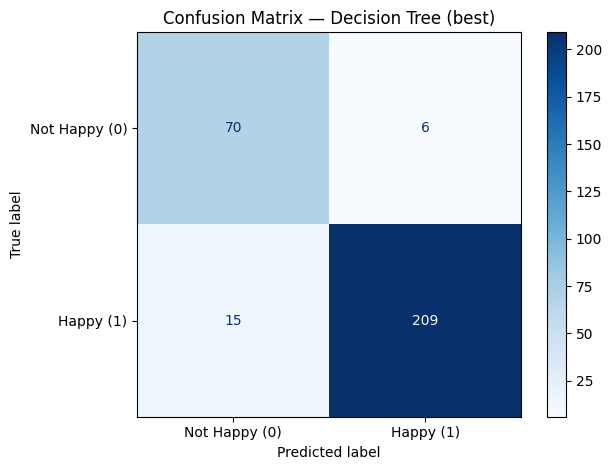

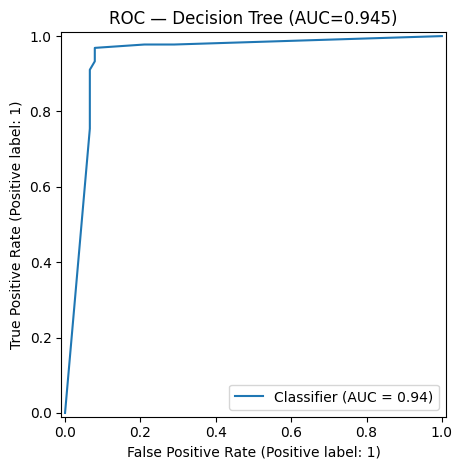

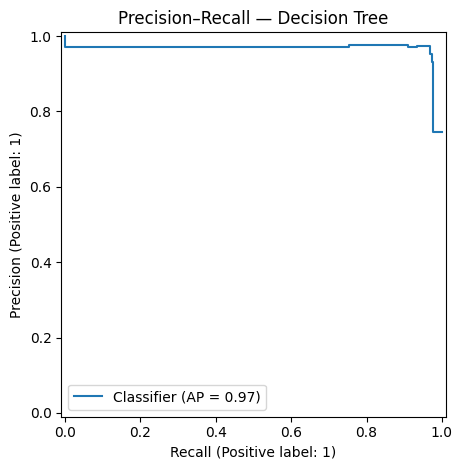

In [26]:
# 0) Chuẩn bị thư mục xuất ảnh
out_dir = "SourceImage/decisiontree"
os.makedirs(out_dir, exist_ok=True)

# 1) Tính xác suất & AUC (để ghi vào tiêu đề ROC)
y_prob_dt = best_dt.predict_proba(X_test)[:, 1]
auc_dt = roc_auc_score(y_test, y_prob_dt)

# 2) Confusion Matrix
fig_cm = plt.figure(figsize=(5, 4))
ConfusionMatrixDisplay.from_estimator(
    best_dt, X_test, y_test,
    display_labels=["Not Happy (0)", "Happy (1)"],
    cmap="Blues", values_format="d"
)
plt.title("Confusion Matrix — Decision Tree (best)")
plt.tight_layout()
cm_path = os.path.join(out_dir, "cm_dt_best.png")
plt.savefig(cm_path, dpi=300)
plt.close(fig_cm)

# 3) ROC Curve
fig_roc = plt.figure(figsize=(6, 5))
RocCurveDisplay.from_predictions(y_test, y_prob_dt)
plt.title(f"ROC — Decision Tree (AUC={auc_dt:.3f})")
plt.tight_layout()
roc_path = os.path.join(out_dir, "roc_dt_best.png")
plt.savefig(roc_path, dpi=300)
plt.close(fig_roc)

# 4) Precision–Recall Curve
fig_pr = plt.figure(figsize=(6, 5))
PrecisionRecallDisplay.from_predictions(y_test, y_prob_dt)
plt.title("Precision–Recall — Decision Tree")
plt.tight_layout()
pr_path = os.path.join(out_dir, "pr_dt_best.png")
plt.savefig(pr_path, dpi=300)
plt.close(fig_pr)

# 5) Feature Importance (Gini-based)
#    Lấy tên cột nếu X_test là DataFrame, nếu không thì tạo tên giả
if isinstance(X_test, pd.DataFrame):
    feat_names = list(X_test.columns)
else:
    feat_names = [f"f{i}" for i in range(X_test.shape[1])]

imp = np.array(best_dt.feature_importances_)
imp_ser = pd.Series(imp, index=feat_names).sort_values(ascending=False)
k = min(15, len(imp_ser))
top_imp = imp_ser.head(k)[::-1]   # đảo để quan trọng nhất ở trên

plt.figure(figsize=(8, 6))
top_imp.plot(kind="barh")
plt.xlabel("Gini Importance")
plt.title(f"Decision Tree — Top {k} Feature Importances")
plt.tight_layout()
fi_path = os.path.join(out_dir, "feature_importance_dt_gini.png")
plt.savefig(fi_path, dpi=300)
plt.close()

print("Saved:")
print(" -", cm_path)
print(" -", roc_path)
print(" -", pr_path)
print(" -", fi_path)

### Model 3: Logistic Regression

#### Cell 1 - Khởi tạo Pipeline + GridSearchCV

In [27]:


# Thư mục lưu hình
OUT_DIR = "SourceImage/logreg"
os.makedirs(OUT_DIR, exist_ok=True)

# Kiểm tra dữ liệu đã có từ trước
try:
    X_train, X_test, y_train, y_test
except NameError as e:
    raise RuntimeError("Chưa có X_train/X_test/y_train/y_test. Hãy chạy cell chuẩn bị dữ liệu trước.") from e

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe_lr = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(
        solver="saga",            # hỗ trợ cả L1 & L2
        max_iter=5000,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1                 # chỉ có hiệu lực ở một số solver; an toàn để giữ
    ))
])

param_grid_lr = {
    "clf__penalty": ["l2", "l1"],
    "clf__C": [0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0]
}

scoring = {
    "roc_auc": "roc_auc",
    "f1_macro": "f1_macro",
    "accuracy": "accuracy"
}

grid_lr = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_grid_lr,
    scoring=scoring,
    refit="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=False
)

grid_lr.fit(X_train, y_train)

best_lr = grid_lr.best_estimator_
print("Best params:", grid_lr.best_params_)
print("Best CV ROC-AUC: {:.4f}".format(grid_lr.best_score_))

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best params: {'clf__C': 5.0, 'clf__penalty': 'l1'}
Best CV ROC-AUC: 0.9570


 #### Cell 2 - Đánh giá trên test set + bảng chỉ số

In [28]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Dự đoán
y_pred_lr  = best_lr.predict(X_test)
y_prob_lr  = best_lr.predict_proba(X_test)[:, 1]

# Chỉ số
acc  = accuracy_score(y_test, y_pred_lr)
auc  = roc_auc_score(y_test, y_prob_lr)

print("=== Classification Report (Logistic Regression) ===")
print(classification_report(y_test, y_pred_lr, target_names=["Not Happy (0)", "Happy (1)"]))
print(f"Test Accuracy: {acc:.4f}")
print(f"Test ROC-AUC : {auc:.4f}")

=== Classification Report (Logistic Regression) ===
               precision    recall  f1-score   support

Not Happy (0)       0.85      0.89      0.87        76
    Happy (1)       0.96      0.95      0.95       224

     accuracy                           0.93       300
    macro avg       0.91      0.92      0.91       300
 weighted avg       0.93      0.93      0.93       300

Test Accuracy: 0.9333
Test ROC-AUC : 0.9612


#### Cell 3 - Vẽ ROC, PR, Confusion Matrix

In [29]:
# ROC
plt.figure(figsize=(7,5))
RocCurveDisplay.from_predictions(y_test, y_prob_lr)
plt.title(f"ROC — Logistic Regression (AUC={roc_auc_score(y_test, y_prob_lr):.3f})")
plt.tight_layout()
roc_path = os.path.join(OUT_DIR, "roc_lr_best.png")
plt.savefig(roc_path, dpi=300)
plt.close()

# PR
plt.figure(figsize=(7,5))
PrecisionRecallDisplay.from_predictions(y_test, y_prob_lr)
plt.title("Precision–Recall — Logistic Regression")
plt.tight_layout()
pr_path = os.path.join(OUT_DIR, "pr_lr_best.png")
plt.savefig(pr_path, dpi=300)
plt.close()

# Confusion Matrix
plt.figure(figsize=(6,5))
ConfusionMatrixDisplay.from_estimator(
    best_lr, X_test, y_test,
    display_labels=["Not Happy (0)", "Happy (1)"],
    cmap="Blues", values_format="d"
)
plt.title("Confusion Matrix — Logistic Regression (best)")
plt.tight_layout()
cm_path = os.path.join(OUT_DIR, "cm_lr_best.png")
plt.savefig(cm_path, dpi=300)
plt.close()

print("Saved:")
print(" -", roc_path)
print(" -", pr_path)
print(" -", cm_path)

Saved:
 - SourceImage/logreg/roc_lr_best.png
 - SourceImage/logreg/pr_lr_best.png
 - SourceImage/logreg/cm_lr_best.png


<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

#### Cell 4 - Phân tích hệ số (Feature Importance theo hệ số)

In [30]:

# Lấy tên cột
if isinstance(X_train, pd.DataFrame):
    feat_names = list(X_train.columns)
else:
    feat_names = [f"f{i}" for i in range(X_train.shape[1])]

# Lấy mô hình Logistic bên trong pipeline
clf_lr = best_lr.named_steps["clf"]

# Hệ số cho bài toán nhị phân -> vector (n_features,)
coef = clf_lr.coef_.ravel()

coef_ser = pd.Series(coef, index=feat_names)
coef_abs = coef_ser.abs().sort_values(ascending=False)

k = min(15, len(coef_abs))
top_feats = coef_abs.head(k).index
top_df = pd.DataFrame({
    "feature": top_feats,
    "coef": coef_ser.loc[top_feats].values
}).set_index("feature").sort_values(by="coef")  # để vẽ barh đẹp

plt.figure(figsize=(8, 6))
top_df["coef"].plot(kind="barh")
plt.xlabel("Coefficient (after StandardScaler)")
plt.title(f"Logistic Regression — Top {k} |coef| coefficients")
plt.tight_layout()
coef_path = os.path.join(OUT_DIR, "coef_lr_top15.png")
plt.savefig(coef_path, dpi=300)
plt.close()

print("Saved:", coef_path)

Saved: SourceImage/logreg/coef_lr_top15.png
